## Installation des librairies

In [2]:
#!pip install torch
#!pip install grad-cam
#!pip install opencv-python
#!pip install opencv-python-headless
#!pip install seaborn
#!pip install pandas


Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 2.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 5.7 MB/s eta 0:00:0000:0100:01
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38071 sha256=97a9c17634b1578e29b2cf4d8cf96ede52977261f4bd81715aedd9bfbb300269
  Stored in directory: /Users/jasonperez/Library/Caches/pip/wheels/d7/8e/bd/167dc45902e8c764698ac16696140fbb8c4323ed2afe03265c
Successfully built grad-cam
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torc

## Importation des différentes librairies et vérification de la précense du gpu sur la machine

In [21]:
local_path  = 'car_data/car_data' # Veuillez remplacer ce chemin vers le dossier contenant test et train
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import time
import os
import PIL.Image as Image
from IPython.display import display
from torchvision.models import resnet18, ResNet18_Weights
from pytorch_grad_cam import GradCAM
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2  # Importer OpenCV pour le redimensionnement
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## Affichage de la répartition des voiitures par classes 

In [22]:
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count


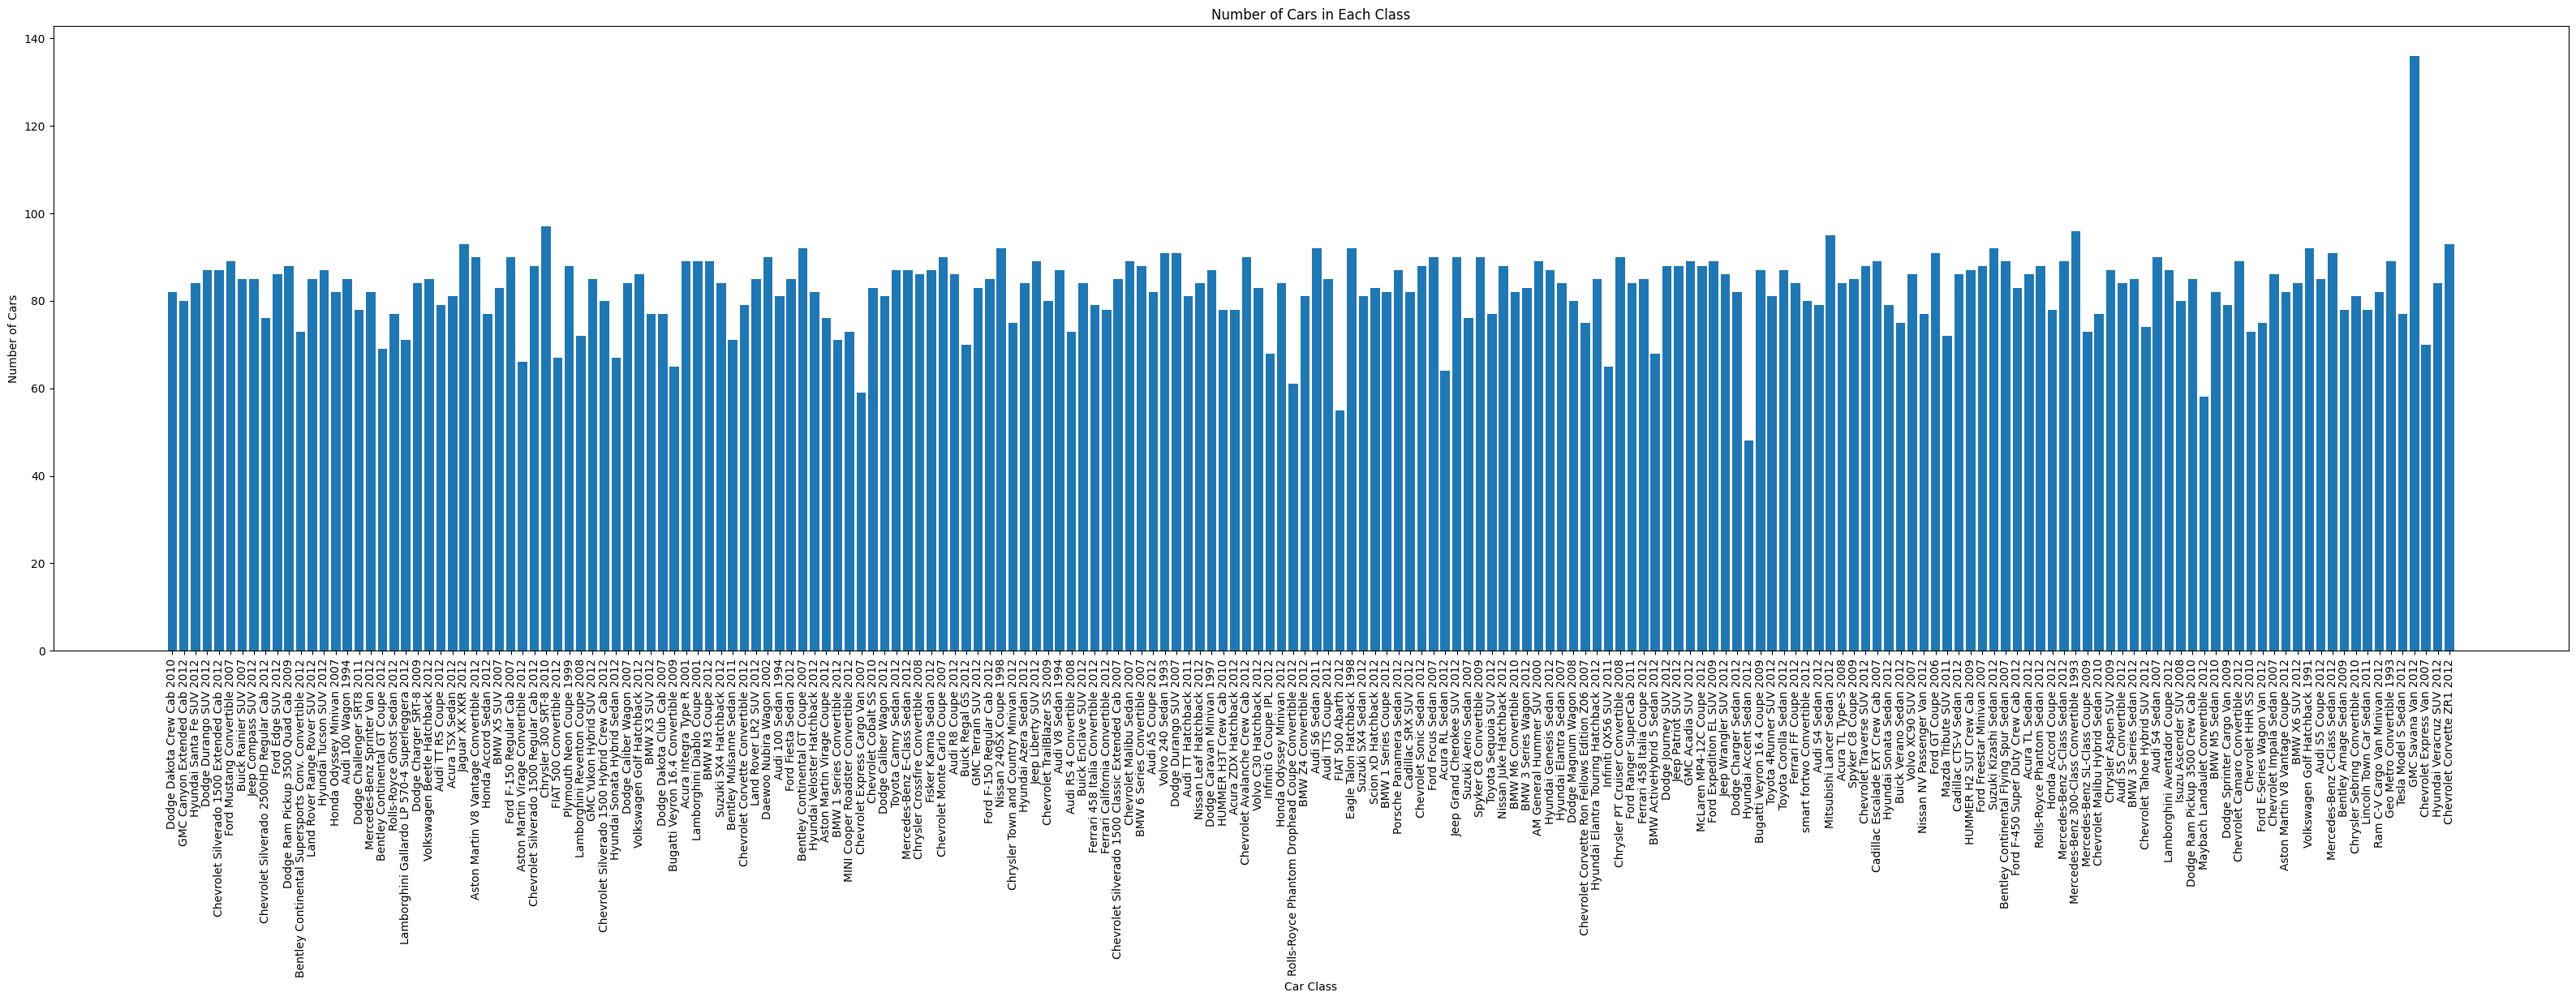

In [23]:
plt.figure(figsize=(40, 10))
    # Creéation d'un graphique en barre
plt.bar(car_count_dict.keys(), car_count_dict.values())


plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

plt.xticks(rotation=90)
plt.savefig('image.png', bbox_inches='tight')
plt.show()


In [24]:
dataset_dir = local_path
# augmentation du jeu de donnée pour éviter l'overfitting
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_time_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)

test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)


## Affichage des images augmentées

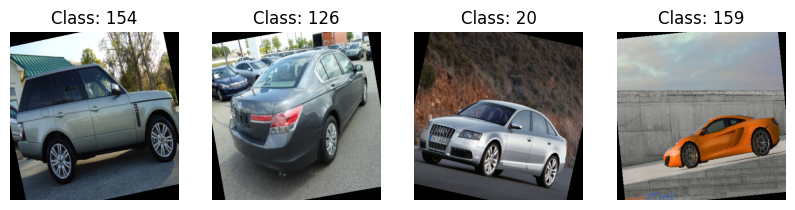

In [25]:
def show_images(images, labels):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 4))
    for ax, image, label in zip(axes, images, labels):
        image = image.numpy().transpose((1, 2, 0))  
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean

        ax.imshow(image)
        ax.set_title(f'Class: {label}')
        ax.axis('off')

    plt.show()
images, labels = next(iter(train_loader))
show_images(images[:4], labels[:4])


## Chargement du modèle

In [26]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# affichage du nombre de classes 
no_classes = len(train_dataset.classes)
# Affichage de l'architecture du modèle
model.parameters


<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [27]:
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# définition de la log fonctio de de l'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)


In [8]:
## Définition de la fonction train_model()


In [43]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    # Itération sur chaque epoch
    for epoch in tqdm(range(n_epochs)):
        # sauvegarde le temps de chaque epoch
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        # iteration sur le train set
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # calcule de la loss
            running_loss += loss.item()
            # calcul de l'accuracy
            running_correct += (labels==predicted).sum().item()
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        # Evaluation du modèle sur le test
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


## Evalutation du modèle

In [44]:
def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    # Application de la transoformation aux images 
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    augmented_images.extend(augmented_imgs)
                images = torch.stack(augmented_images)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            # Nombre des prédictions totales
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calcul de la précision
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc


In [35]:
#Code à décommenter si on veut entrainer le modèle
#n_epochs = 10
# train the model
#model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            #test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Save the model
#torch.save(model.state_dict(), 'model.pth')


In [18]:
#affichage de l'évolution de la training loss et de la training accuracy après l'entrainement
'''fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()'''


'fig, axs = plt.subplots(1, 2, figsize=(12, 4))\n\n# Plot training loss\naxs[0].plot(training_losses)\naxs[0].set_title("Training Loss")\n\n# Plot training and test accuracy\naxs[1].plot(training_accs, label="Training Accuracy")\naxs[1].plot(test_accs, label="Test Accuracy")\naxs[1].set_title("Training and Test Accuracy")\naxs[1].legend()\n\nplt.tight_layout()\nplt.show()'

In [45]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(os.path.join(dataset_dir, 'train'))


## Codage d'une heatmap

In [46]:
model.load_state_dict(torch.load('model.pth', map_location='cpu'))
model.eval()

loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin Virage Coupe 2012/00757.jpg'
image = Image.open(os.path.join(dataset_dir, 'test', random_image_name))
# Affichage de l'image prédit 
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
#image = image.cuda()
start_time = time.time()

output = model(image)

# Mesurer le temps après l'inférence
end_time = time.time()

# Calculer le temps écoulé pour l'inférence
inference_time = end_time - start_time
 
conf, predicted = torch.max(output.data, 1)

# Afficher le temps d'inférence
print("Temps d'inférence:", inference_time, "secondes")


Temps d'inférence: 0.07446074485778809 secondes


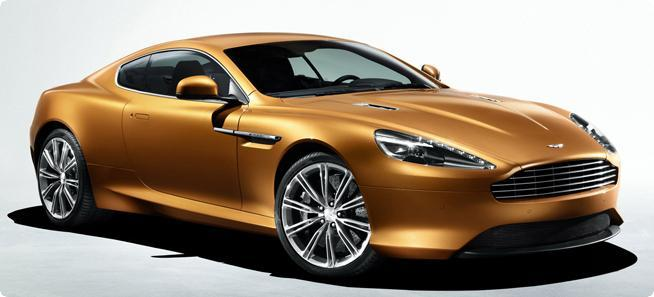

Aston Martin Virage Coupe 2012 confidence:  14.416364669799805


In [47]:
display(Image.open(os.path.join(dataset_dir, 'test', random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())


In [ ]:
# il faut tourner sur cpu pour pouvoir lancer sans soucis cette partie décommenté
'''true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Obtention des labels prédit
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Génération de la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

#Affichage de la précision et du rappel
cr = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)'''


In [ ]:
# Il faut avoir lancer la matrice de confusion( code du dessus) pour pouvoir executer ce code
'''import seaborn as sns
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm, index=range(10), columns=range(10))
# Sélection de 10 classes au hasard
random_classes = np.random.choice(range(196), size=10, replace=False)

# Création de la matrice de confusion pour ces classes
subset_cm = cm_df.iloc[random_classes, random_classes]

# Configuration de la taille du graphique
plt.figure(figsize=(10, 7))

# Création de la heatmap
sns.heatmap(subset_cm, annot=True, cmap='Blues', fmt='g')

# Ajout de labels et de titre
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion (Classes au Hasard)')

# Affichage du graphique
plt.savefig('confusion.png', transparent=False)
plt.show()
'''


Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/01012.jpg
Audi 100 Wagon 1994


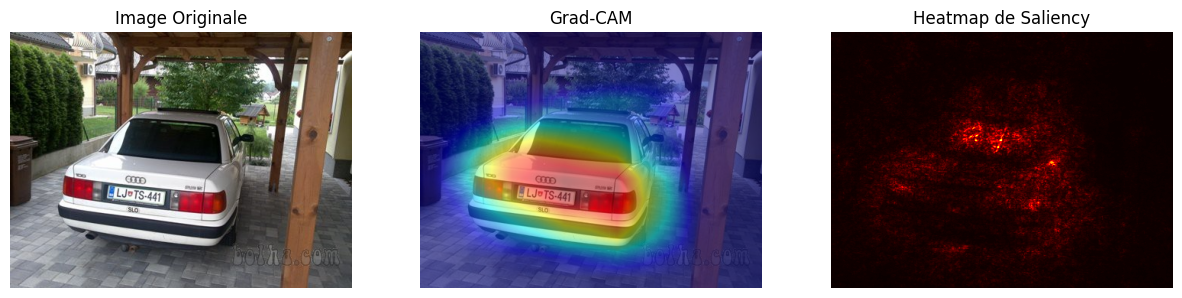

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/01893.jpg
Audi V8 Sedan 1994


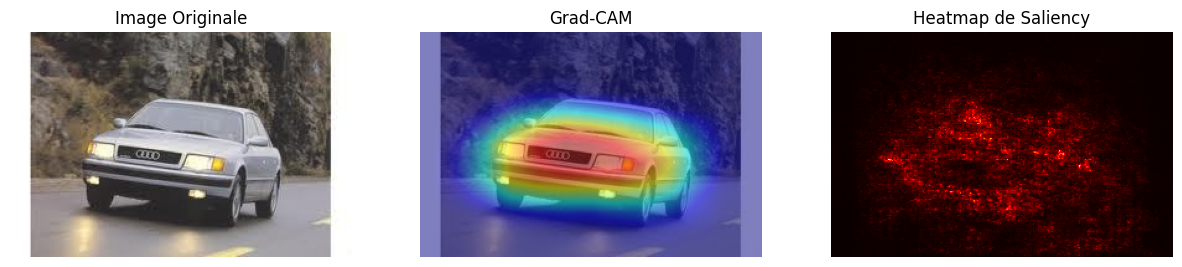

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/03791.jpg
Audi 100 Sedan 1994


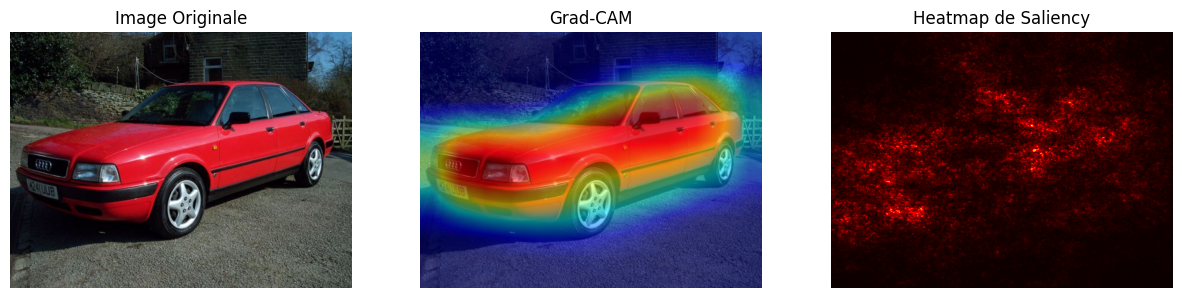

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/02143.jpg
Audi 100 Sedan 1994


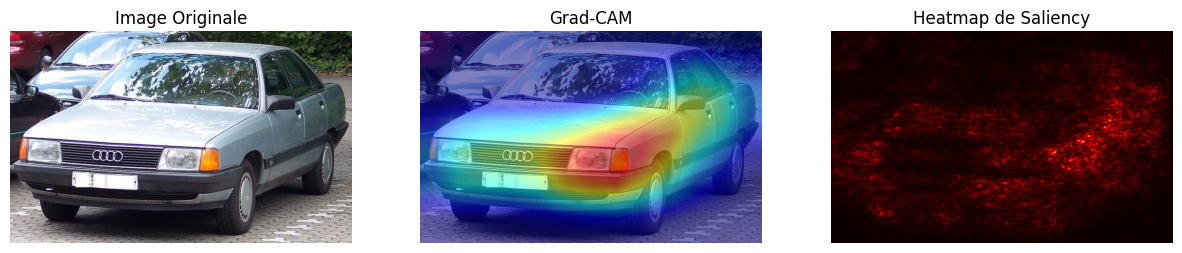

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/05077.jpg
Audi 100 Sedan 1994


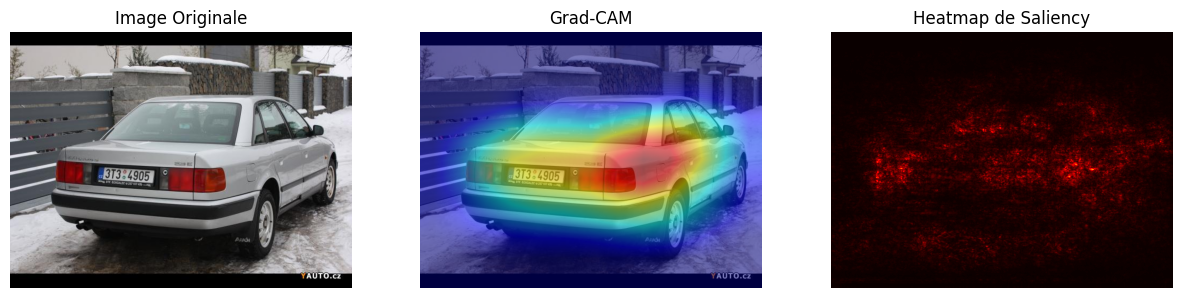

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/04603.jpg
Audi 100 Sedan 1994


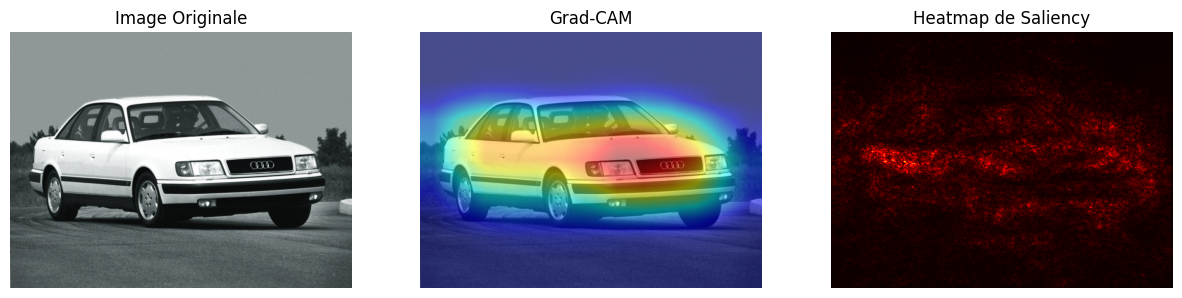

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/04644.jpg
Audi 100 Sedan 1994


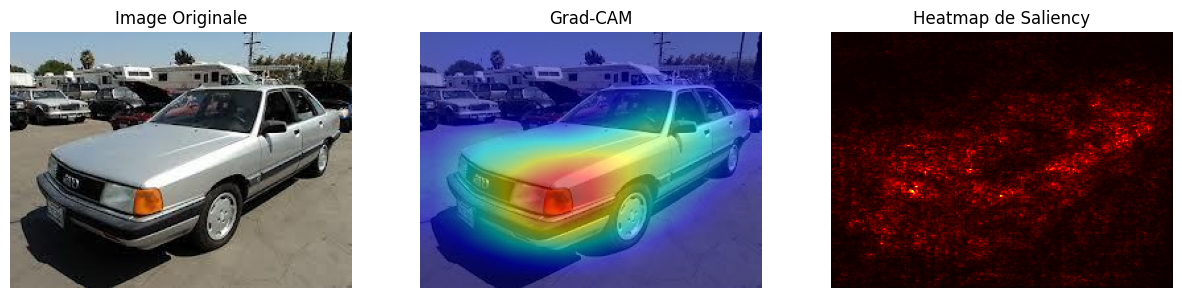

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/07381.jpg
Audi 100 Sedan 1994


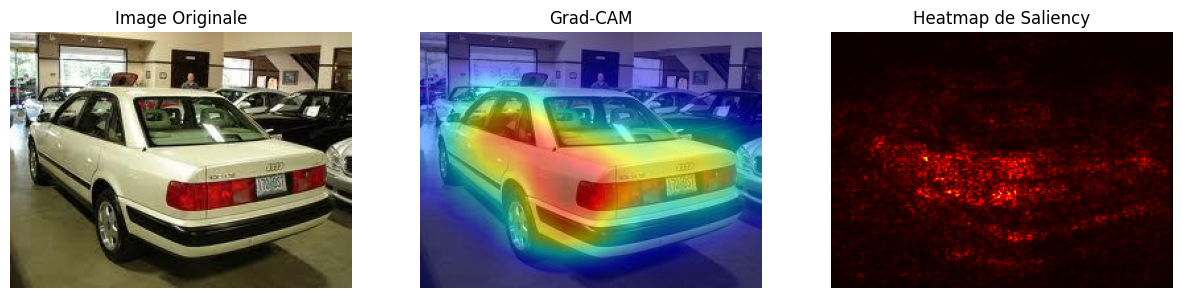

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/00891.jpg
Audi 100 Sedan 1994


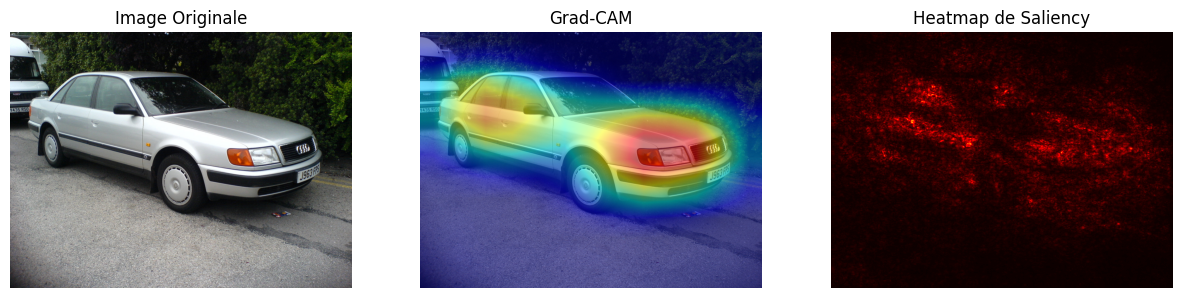

Chemin de l'image choisie: car_data/car_data/test/Audi 100 Sedan 1994/05935.jpg
Audi 100 Sedan 1994


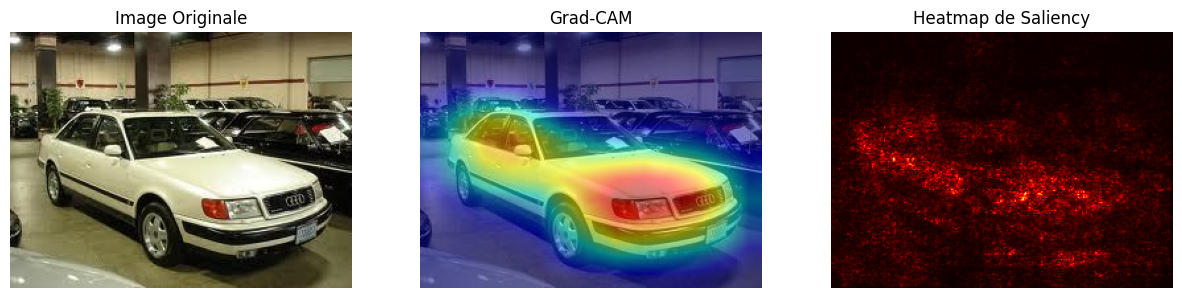

In [48]:
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))
model.eval()
#model.cuda()
# Initialiser Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Préparer le transform
loader = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Sélectionner un dossier au hasard
newpath = os.path.join(dataset_dir, 'test')
random_folder = random.choice(os.listdir(newpath))
random_folder_path = os.path.join(newpath, random_folder)

# Sélectionner 10 fichiers image au hasard dans le dossier choisi
random_images = random.sample(os.listdir(random_folder_path), 10)

# Traitement pour chaque image
for image_name in random_images:
    image_path = os.path.join(random_folder_path, image_name)
    print("Chemin de l'image choisie:", image_path)
    img = Image.open(image_path)
    original_img = np.array(img)  # Convertir en array numpy
    img_tensor = loader(img).unsqueeze(0)

    # Prédiction du modèle
    output = model(img_tensor)
    conf, predicted = torch.max(output.data, 1)

    # Calcul de la Grad-CAM
    grayscale_cam = cam(input_tensor=img_tensor, eigen_smooth=False)
    grayscale_cam = grayscale_cam[0, :]
    grayscale_cam_resized = cv2.resize(grayscale_cam, (original_img.shape[1], original_img.shape[0]))
    visualization = show_cam_on_image(original_img/255.0, grayscale_cam_resized, use_rgb=True)

    # Calcul de la Saliency Map
    img_tensor.requires_grad = True
    output = model(img_tensor)
    score, index = torch.max(output, 1)
    score.backward()
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
    saliency = saliency.reshape(400, 400)
    saliency = cv2.resize(saliency.cpu().data.numpy(), (original_img.shape[1], original_img.shape[0]))
    # Affichage de la classe prédite
    print(classes[predicted.item()])

    # Affichage des résultats pour chaque image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Image Originale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(saliency, cmap='hot')
    plt.title("Heatmap de Saliency")
    plt.axis('off')

    plt.show()
